In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/HeatherKacmarski/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Comparing LSA, LDA, and NNMF
Now that you've been introduced to the logic behind these three topic extraction methods, we're going to try them out on the Emma corpus. We'll be looking at interpretability, speed, and consistency across methods. The goal is to identify common themes in Emma on a per-paragraph basis. We won't be using pLSA as sklearn does not support it.

To do this, we will:

* Parse and process the data into a tf-idf matrix.
* Fit LSA, LDA, and NNMF models with 5 topics each.
* Extract the words that best describe each topic.
* Examine the topic relationships for the words 'marriage', 'love', and 'Emma.'
* Generating the tfidf matrix

In [39]:
# Processing the data.

from nltk.corpus import gutenberg
import re
from sklearn.feature_extraction.text import TfidfVectorizer


#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=5

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    test=[]
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
        print(topwords)
        test.append(chosenlist)
    return(topwords,test)

# Number of words to look at for each topic.
n_top_words = 10



In addition to creating the tfidf matrix, there are two convenience functions that will help keep the code tidy when comparing models. The first provides a list of the words that are paired with each topic. The second gives us the best words for each topic so we can compare across methods.

### Fitting the three topic extraction models

In [26]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
emma_paras_lsa = lsa.fit_transform(emma_paras_tfidf)

components_lsa = word_topic(emma_paras_tfidf, emma_paras_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                

oh             9.761117e+01
yes            4.892888e+00
thank          1.622185e+00
difference     1.576046e+00
just           1.437394e+00
harriet        1.342707e+00
sorry          1.283096e+00
short          1.174004e+00
papa           1.150943e+00
cried          1.021531e+00
recollect      1.020565e+00
answer         9.332074e-01
talking        9.324808e-01
week           8.197698e-01
letter         8.176103e-01
great          7.546124e-01
think          7.262944e-01
know           7.248908e-01
miss           7.227750e-01
habit          6.359528e-01
sir            6.238027e-01
did            6.187354e-01
good           6.146707e-01
remember       6.128502e-01
declare        6.089615e-01
_names_        6.073301e-01
emma           5.835502e-01
situation      5.729197e-01
observe        5.572133e-01
read           5.474710e-01
                   ...     
plague         1.607624e-04
imprudent      1.426095e-04
mad            1.426095e-04
_court_        1.197834e-04
swisserland    4.974

In [27]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [28]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

emma_paras_lda = lda.fit_transform(emma_paras_tfidf) 

components_lda = word_topic(emma_paras_tfidf, emma_paras_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

emma               13.302799
harriet            12.733679
mr                 11.599147
said               10.200687
oh                  9.986817
think               9.477891
mrs                 9.129628
chapter             8.691817
quite               7.786571
miss                7.118750
jane                7.049132
replied             6.704246
dear                6.498051
elton               6.028595
fairfax             5.820602
knightley           5.773636
weston              5.495161
good                5.394592
doubt               5.358215
right               4.753432
like                4.704226
yes                 4.619559
friend              4.483208
hear                4.401380
know                4.357670
hartfield           4.255748
did                 4.241871
sure                4.157362
thought             3.914964
little              3.875715
                     ...    
solitary            0.003428
dangers             0.003428
peace               0.003428
solicitous    

In [29]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
emma_paras_nmf = nmf.fit_transform(emma_paras_tfidf) 

components_nmf = word_topic(emma_paras_tfidf, emma_paras_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

oh              30.121739
yes              0.520804
sorry            0.158463
difference       0.147596
just             0.121000
papa             0.117495
week             0.111563
short            0.110593
recollect        0.099065
letter           0.092602
answer           0.089023
harriet          0.086801
cried            0.082745
talking          0.073957
great            0.067617
habit            0.067339
thank            0.066671
declare          0.065683
_names_          0.059903
situation        0.057447
sympathy         0.055125
mentioned        0.051912
observe          0.051217
know             0.045422
seriously        0.042339
remember         0.041961
think            0.041085
read             0.040458
miss             0.040426
deal             0.039974
                  ...    
reckon           0.000000
expedition       0.000000
refined          0.000000
expense          0.000000
experience       0.000000
experienced      0.000000
regarded         0.000000
explain     

We are mostly using the default settings for each method, but explicitly printing them so it is clear what is going on and how each model can be modified. sklearn has such nice parallel structure for its various topic extraction methods that we could probably have abstracted the code even further.

### Inspecting the topics
For each topic, we list the ten most-relevant words according to each method:

In [30]:
components_lsa

,0,1,2,3,4
000,1.088161e-03,0.124368,-0.003996,0.000212,0.044161
10,1.088161e-03,0.124368,-0.003996,0.000212,0.044161
1816,1.462670e-03,0.412478,-0.010381,-0.004480,-0.497934
23rd,3.935947e-02,0.385220,-0.011277,-0.000241,-0.088363
24th,2.315206e-03,0.255713,-0.007283,0.000342,0.001852
8th,3.935947e-02,0.385220,-0.011277,-0.000241,-0.088363
_accepted_,2.990507e-03,0.375587,0.005537,0.002015,0.011227
_amor_,1.123998e-03,0.229053,-0.003166,-0.000385,-0.085714
_as_,3.030845e-03,0.320820,-0.009517,-0.000006,0.122436
_been_,4.801655e-03,0.291764,-0.005851,-0.002418,-0.033820


In [31]:
n_top_words

10

In [40]:
a,b = top_words(components_lsa, n_top_words)

0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
dtype: object
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
dtype: object
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN


In [41]:
a

0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
0    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
2    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
3    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
4    NaN
dtype: object

In [42]:
b

[oh                   oh 97.61
 yes                  yes 4.89
 thank              thank 1.62
 difference    difference 1.58
 just                just 1.44
 harriet          harriet 1.34
 sorry              sorry 1.28
 short              short 1.17
 papa                papa 1.15
 cried              cried 1.02
 dtype: object, emma          emma 58.07
 mr              mr 58.06
 said           said 50.5
 mrs            mrs 47.14
 miss          miss 37.67
 harriet    harriet 35.77
 weston      weston 32.24
 elton         elton 27.9
 did            did 27.64
 think        think 26.44
 dtype: object, ah               ah 31.15
 sure            sure 3.43
 say              say 1.11
 believe      believe 0.83
 sorry          sorry 0.81
 hands           hands 0.5
 shake           shake 0.5
 grievous    grievous 0.44
 poor            poor 0.41
 spring         spring 0.4
 dtype: object, chapter    chapter 33.91
 ii                ii 3.2
 iii              iii 3.2
 ix               ix 2.52
 xiii      

In [43]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
   LSA  LDA NNMF
0  NaN  NaN  NaN
0  NaN  NaN  NaN
0  NaN  NaN  NaN
0  NaN  NaN  NaN
0  NaN  NaN  NaN
0  NaN  NaN  NaN
0  NaN  NaN  NaN
0  NaN  NaN  NaN
0  NaN  NaN  NaN
0  NaN  NaN  NaN
Topic 1:
   LSA  LDA NNMF
1  NaN  NaN  NaN
1  NaN  NaN  NaN
1  NaN  NaN  NaN
1  NaN  NaN  NaN
1  NaN  NaN  NaN
1  NaN  NaN  NaN
1  NaN  NaN  NaN
1  NaN  NaN  NaN
1  NaN  NaN  NaN
1  NaN  NaN  NaN
Topic 2:
   LSA  LDA NNMF
2  NaN  NaN  NaN
2  NaN  NaN  NaN
2  NaN  NaN  NaN
2  NaN  NaN  NaN
2  NaN  NaN  NaN
2  NaN  NaN  NaN
2  NaN  NaN  NaN
2  NaN  NaN  NaN
2  NaN  NaN  NaN
2  NaN  NaN  NaN
Topic 3:
   LSA  LDA NNMF
3  NaN  NaN  NaN
3  NaN  NaN  NaN
3  NaN  NaN  NaN
3  NaN  NaN  NaN
3  NaN  NaN  NaN
3  NaN  NaN  NaN
3  NaN  NaN  NaN
3  NaN  NaN  NaN
3  NaN  NaN  NaN
3  NaN  NaN  NaN
Topic 4:
   LSA  LDA NNMF
4  NaN  NaN  NaN
4  NaN  NaN  NaN
4  NaN  NaN  NaN
4  NaN  NaN  NaN
4  NaN  NaN  NaN
4  NaN  NaN  NaN
4  NaN  NaN  NaN
4  NaN  NaN  NaN
4  NaN  NaN  NaN
4  NaN  NaN  NaN


A number of things are clear. First, some topics are shared, though the order of topics varies- the 'oh' topic is first for LSA and NNMF, but second for LDA. And second, the content of some of the topics varies considerably across methods. This is a clear argument for using multiple methods when exploring topics.

### Sparsity
Now let's examine sparsity by looking at the distributions of loadings for the words 'marriage', 'love', 'emma', and 'oh' across the methods:

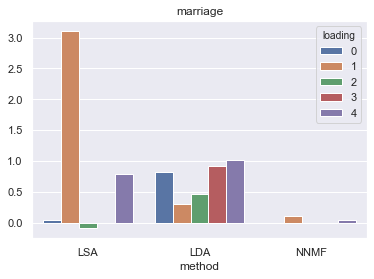

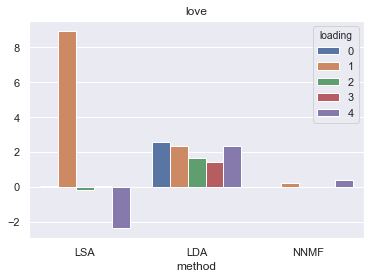

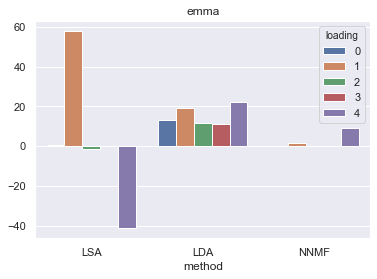

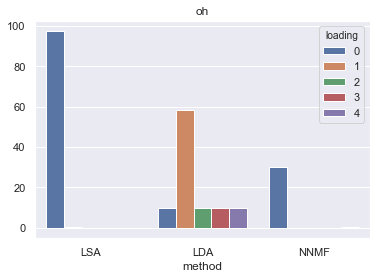

In [44]:
# The words to look at.
targetwords=['marriage','love','emma','oh']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()

LSA is the method most likely to have high loadings on more than one topic for the same word. LDA tends to have one high loading and some lower loadings. Loadings for NNMF are lower all around, and the most sparse, with some of the topics having loadings of zero on each word.

### Challenge: Topic extraction on new data
Take the well-known 20 newsgroups dataset and use each of the methods on it. Your goal is to determine which method, if any, best reproduces the topics represented by the newsgroups. Write up a report where you evaluate each method in light of the 'ground truth'- the known source of each newsgroup post. Which works best, and why do you think this is the case?

In [45]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [46]:
from pprint import pprint
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
